In [135]:
import sys

import networkx as nx
import igraph as ig
from networkx.generators.community import LFR_benchmark_graph

import numpy as np
import time

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15

#sys.path.append("/home/oriol/Documents/Trento/JacobianGeometry/Code/Dynamics_v2/")
#sys.path.append("/Users/giacomobarzon/Desktop/jacobian_geometry/Code_8thJune/Dynamics_v2/")
sys.path.append("/home/barzon/Network_geometry/Code_8thJune/Dynamics_v2/")

import CommonFunctions as cf

import importlib
importlib.reload(cf)

<module 'CommonFunctions' from '/home/barzon/Network_geometry/Code_8thJune/Dynamics_v2/CommonFunctions.py'>

# Graph generation

In [156]:
N = 128

mean_deg = 4.

In [118]:
# Random graph
pp = mean_deg/N

G_er = nx.fast_gnp_random_graph(N, pp)
while nx.is_connected(G_er) == 0:
    print('The network should be in a single component. New trial!')
    G_er = nx.fast_gnp_random_graph(N, pp)

infoG_er = ['ER',pp]

print('Mean degree', np.mean(list(dict(G_er.degree()).values())))

Mean degree 5.78125


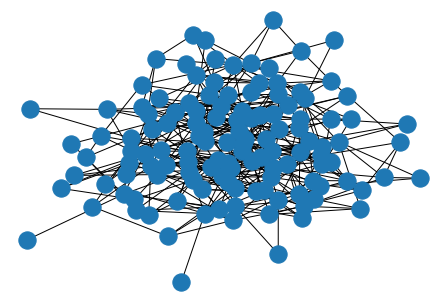

In [119]:
nx.draw(G_er)

In [159]:
num_groups = 4; nodes_per_group = 32; kave = mean_deg; k_out = 0.1#kave is local average
k_in = kave - k_out
p_in = k_in/nodes_per_group
p_out = k_out/(nodes_per_group*num_groups - nodes_per_group)
print('Block model probs: in %f - out %f' % (p_in, p_out))

G_gn = nx.planted_partition_graph(num_groups, nodes_per_group, p_in, p_out, directed=False)

while nx.is_connected(G_gn) == 0:
    print('The network should be in a single component. New trial!')
    G_gn = nx.planted_partition_graph(num_groups, nodes_per_group, p_in, p_out, directed=False)

infoG_gn = ['GN',k_out]

print('Mean degree', np.mean(list(dict(G_gn.degree()).values())))

Block model probs: in 0.121875 - out 0.001042
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
The network should be in a single component. New trial!
Mean degree 4.21875


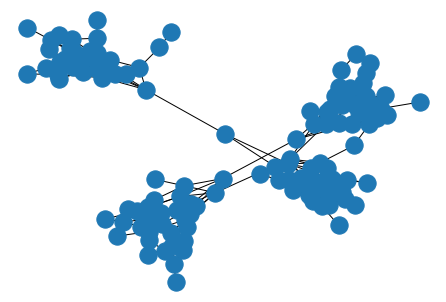

In [160]:
nx.draw(G_gn)

# Diffusion - Jacobian distance

In [124]:
def get_average_matrix(dist):
    maxis = np.max(np.max(dist, axis=2), axis=1)
    dist = dist / maxis[:,None,None]
    return np.mean(dist, axis=0)

In [161]:
dynamics_list = ['Mutualistic', 'Biochemical', 'Population', 'Regulatory',
                    'Epidemics','Synchronization', 'Neuronal', 'NoisyVM']

def Simu(G, infoG):
    """
    Inputs: dynamics (any from  dynamics_list = ['Mutualistic', 'Biochemical', 'Population', 'Regulatory',
                                                 'Epidemics','Synchronization', 'Neuronal', 'NoisyVM'])
            Network topology G
            infoG (list): Info about the network. infoG[0] = network_type; infoG[i>0] = parameters
    """
    print('-------- GRAPH DISTANCES --------')
    start_time = time.time()
    
    num_nodes = G.number_of_nodes()
    num_time_points = 50 # small to decrease computational load
    times = np.linspace(0, 50, num = num_time_points+1) #time to find the steady state    
    times_perturbation = np.linspace(0, 50., num = 101) #times at which we look how the perturbation evolves
    
    if nx.is_connected(G) == 0:
        raise ValueError('The network should be in a single component. Exit!')
    
    res = []
    
    for dynamics in dynamics_list:
    
        ### JACOBIAN
        print('[*] JACOBIAN DISTANCE - '+str(dynamics))
        
        #Integration to get the steady state
        print('Integration up to steady state...')
        initial_state = np.random.random(len(G.nodes()))   
        SteadyState_ref, char_time = cf.Numerical_Integration(G, dynamics, initial_state, times = times, fixed_node = 1e+6, show = 1)
        SteadyState_ref = SteadyState_ref[-1]
        
        if char_time == np.inf:
            char_time = 100**(1/1.7)
        print('Char time: ', char_time)
            

        # analytical expression of Jacobian
        print('Evaluating jacobian distance...')
        d_jac = cf.Jacobian(G, dynamics, SteadyState_ref, times_perturbation, return_snapshot=True)
        #times_perturbation*char_time**1.7/100
        res.append(d_jac)
        
    ### DIFFUSION
    print('[*] DIFFUSION DISTANCE')
    print('Evaluating diffusion distance...')
    d_diff = cf.Laplacian(nx.to_numpy_array(G), times_perturbation, norm=True, return_snapshot=True)
    
    res.append(d_diff)
    
    return res

-------- GRAPH DISTANCES --------
[*] JACOBIAN DISTANCE - Mutualistic
Integration up to steady state...


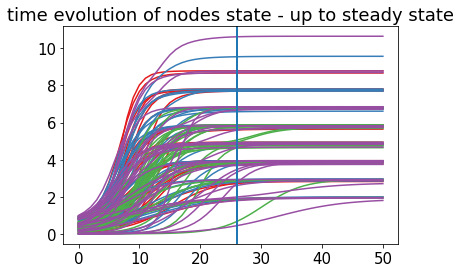

Char time:  26.0
Evaluating jacobian distance...
largest eig: 1.0654804476107462


  0%|          | 0/101 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Biochemical
Integration up to steady state...


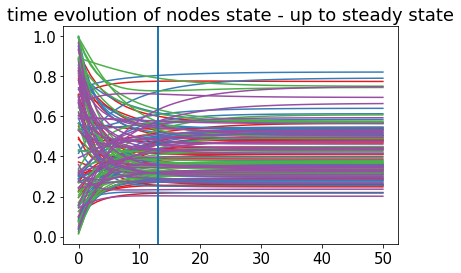

Char time:  13.0
Evaluating jacobian distance...
largest eig: 0.5649754662250135


  0%|          | 0/101 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Population
Integration up to steady state...


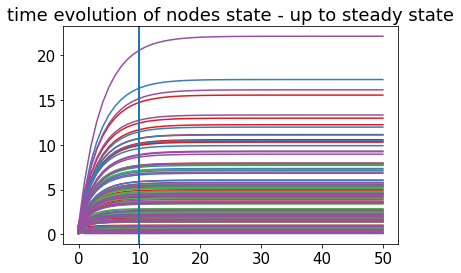

Char time:  10.0
Evaluating jacobian distance...
largest eig: 5.972620894108994


  0%|          | 0/101 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Regulatory
Integration up to steady state...


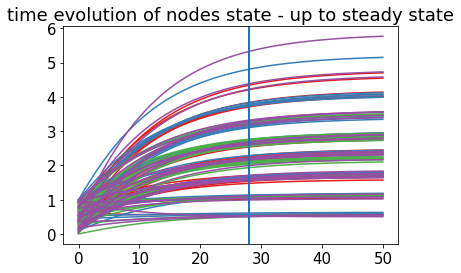

Char time:  28.0
Evaluating jacobian distance...
largest eig: 0.11661332634243264


  0%|          | 0/101 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Epidemics
Integration up to steady state...


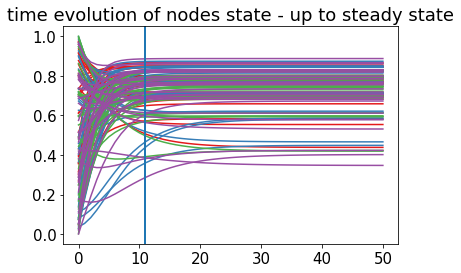

Char time:  11.0
Evaluating jacobian distance...
largest eig: 0.8949804464627429


  0%|          | 0/101 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Synchronization
Integration up to steady state...


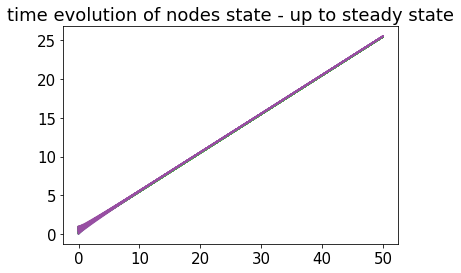

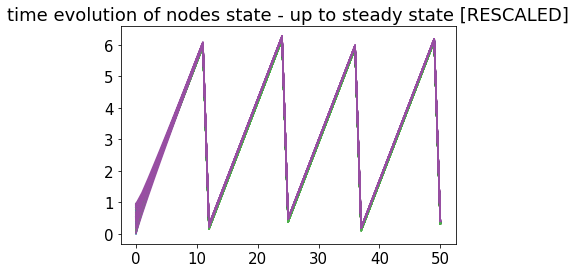

Char time:  15.013107289081734
Evaluating jacobian distance...
largest eig: 5.73783883920019


  0%|          | 0/101 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Neuronal
Integration up to steady state...


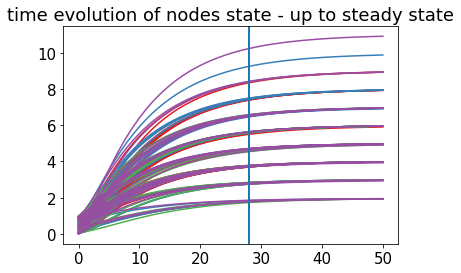

Char time:  28.0
Evaluating jacobian distance...
largest eig: 0.10497944625359384


  0%|          | 0/101 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - NoisyVM
Integration up to steady state...


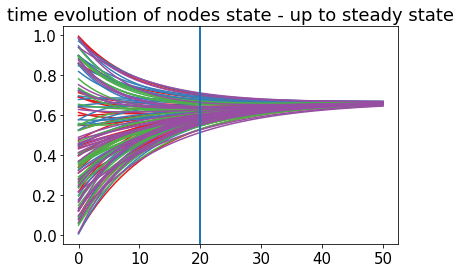

Char time:  20.0
Evaluating jacobian distance...
largest eig: 0.12993945360167863


  0%|          | 0/101 [00:00<?, ?it/s]

[*] DIFFUSION DISTANCE
Evaluating diffusion distance...


  0%|          | 0/101 [00:00<?, ?it/s]

In [162]:
results = Simu(G_gn, infoG_gn)

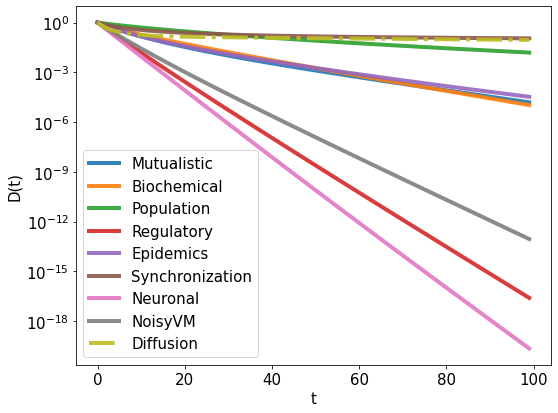

In [163]:
plt.figure(figsize=(8,6))

cutoff = 100

lw = 4.

#plt.subplot(1,2,1)

for i, res in enumerate(results):
    if i==len(dynamics_list):
        plt.plot(res[0][:cutoff]/np.max(res[0]), '-.', label='Diffusion', lw=lw, alpha=0.9)
    else:
        plt.plot(res[0][:cutoff]/np.max(res[0]), label=dynamics_list[i], lw=lw, alpha=0.9)

plt.xlabel('t')
plt.ylabel('D(t)')
plt.yscale('log')
plt.legend()

'''
plt.subplot(1,2,2)

for i, res in enumerate(results):
    if i==len(dynamics_list):
        plt.plot(res[0]/np.max(np.max(res[1],axis=2),axis=1), '-.', label='Diffusion', lw=lw)
    else:
        plt.plot(res[0]/np.max(np.max(res[1],axis=2),axis=1), label=dynamics_list[i], lw=lw)

plt.xlabel('t')
plt.ylabel('norm D(t)')
plt.yscale('log')
plt.legend()
'''

plt.tight_layout()
plt.show()

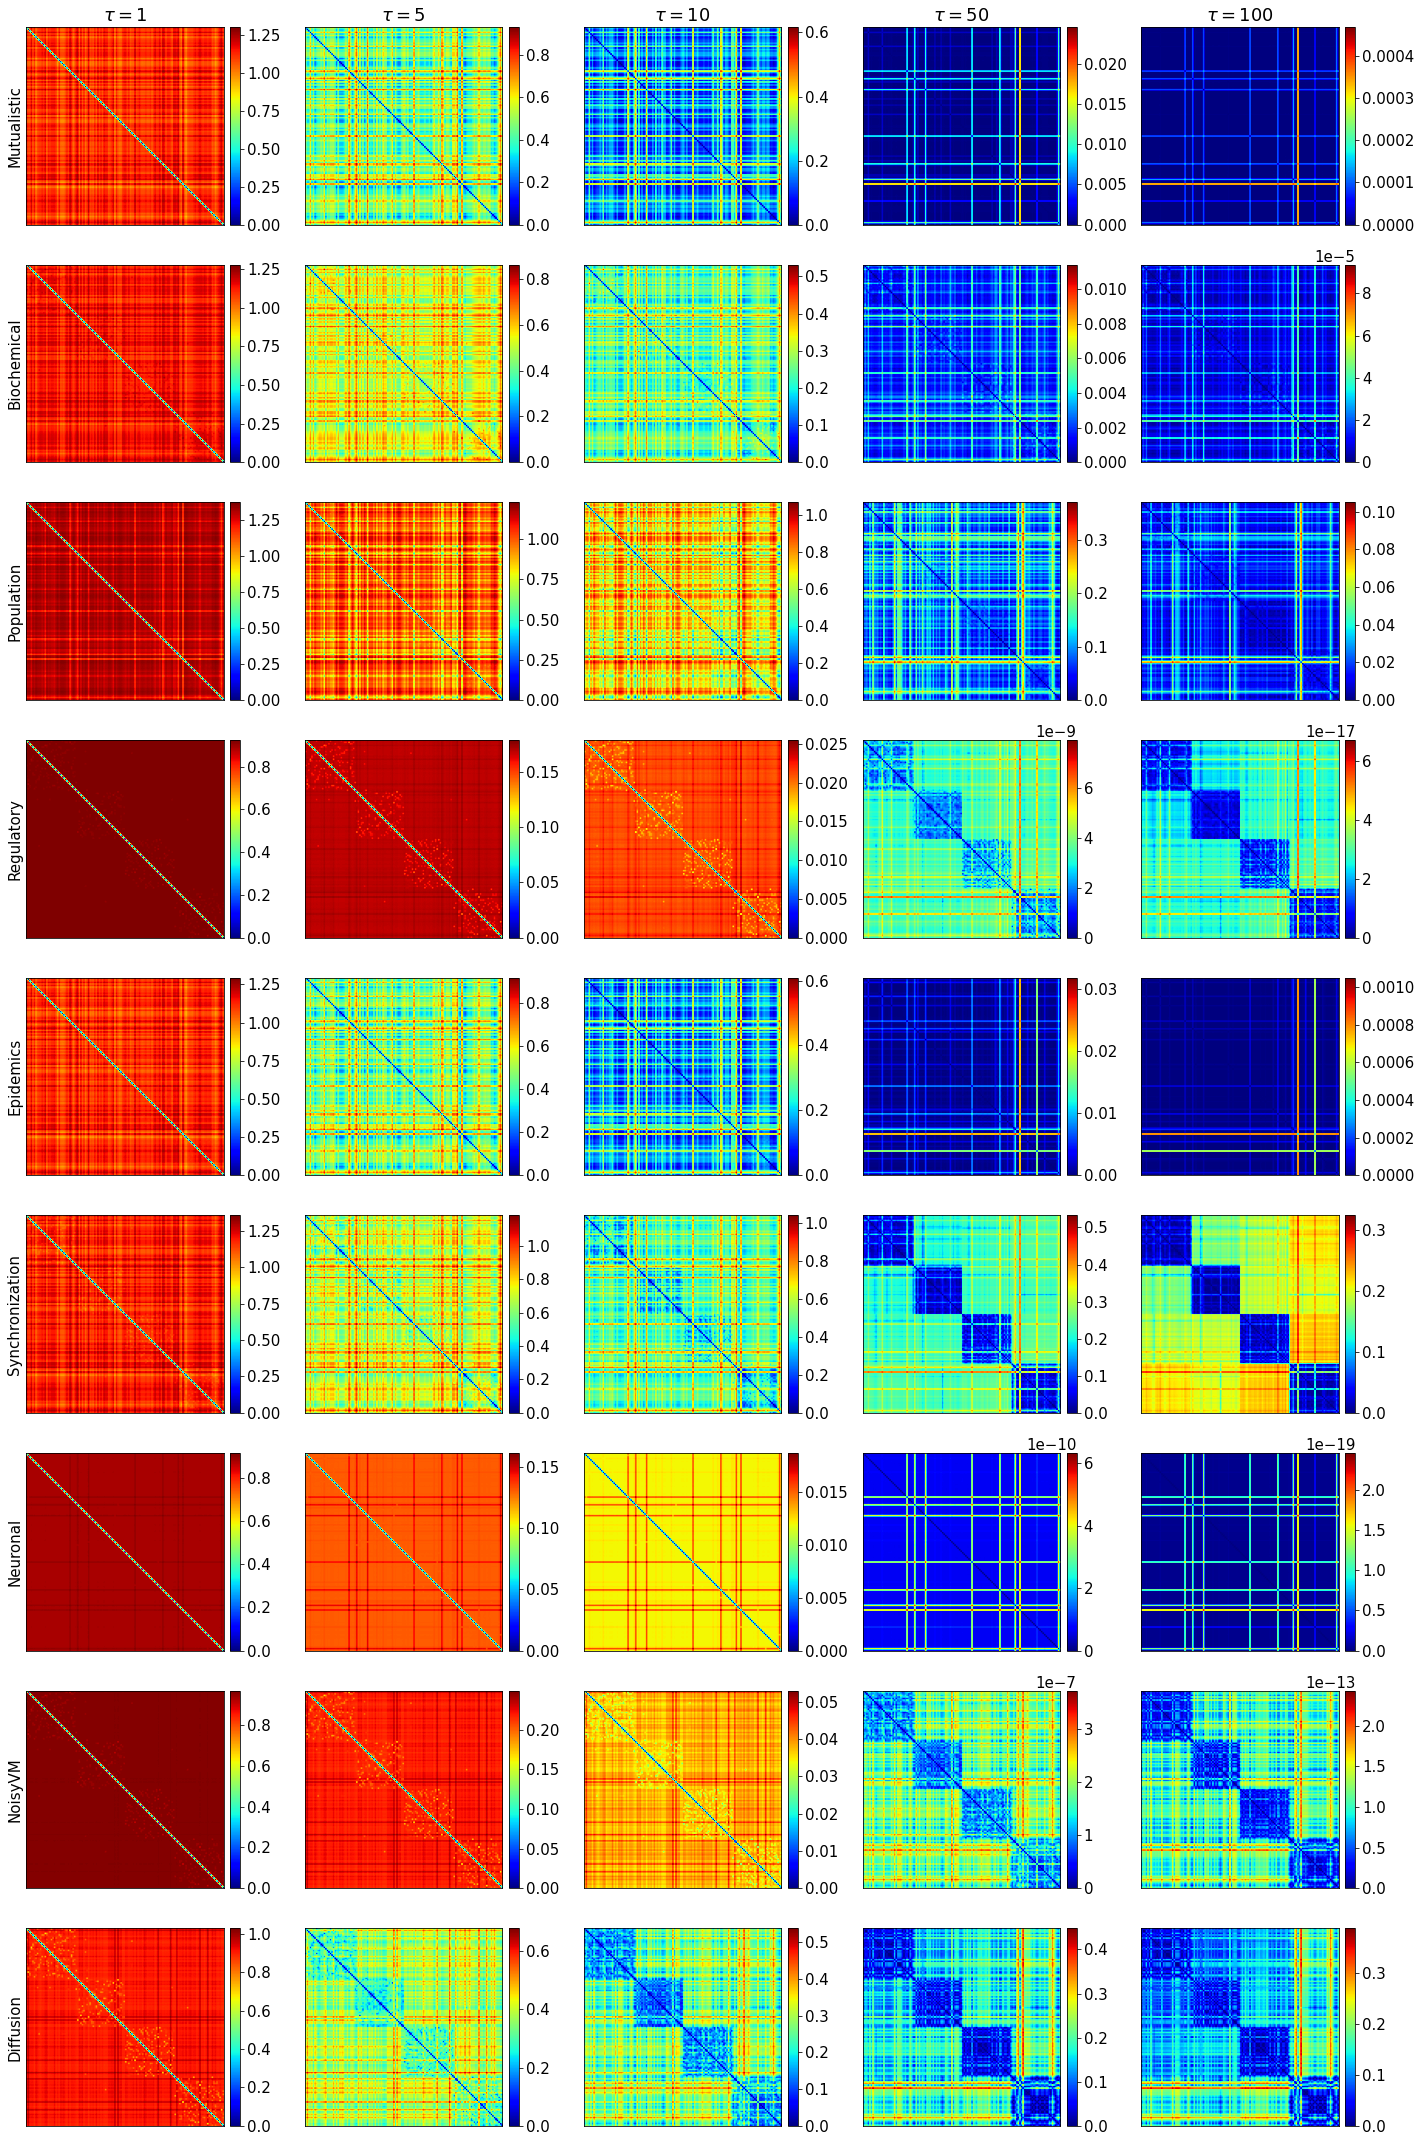

In [164]:
t_print = [1, 5, 10, 50, 100]

plt.figure(figsize=(20,30))

Y = len(t_print)
X = len(dynamics_list)+1

for i, t in enumerate(t_print):
    for j, res in enumerate(results):
        plt.subplot(X,Y, i+1 + j*Y)
    
        im = plt.imshow(res[1][t], cmap='jet')
    
        plt.colorbar(im,fraction=0.046, pad=0.03)
        plt.xticks([])
        plt.yticks([])
        if j==0:
            plt.title(r'$\tau = $'+str(t))
        if i==0:
            if j==X-1:
                plt.ylabel('Diffusion')
            else:
                plt.ylabel(dynamics_list[j])
                
#plt.subplots_adjust(wspace=0, hspace=-1.05)
plt.tight_layout()
plt.show()

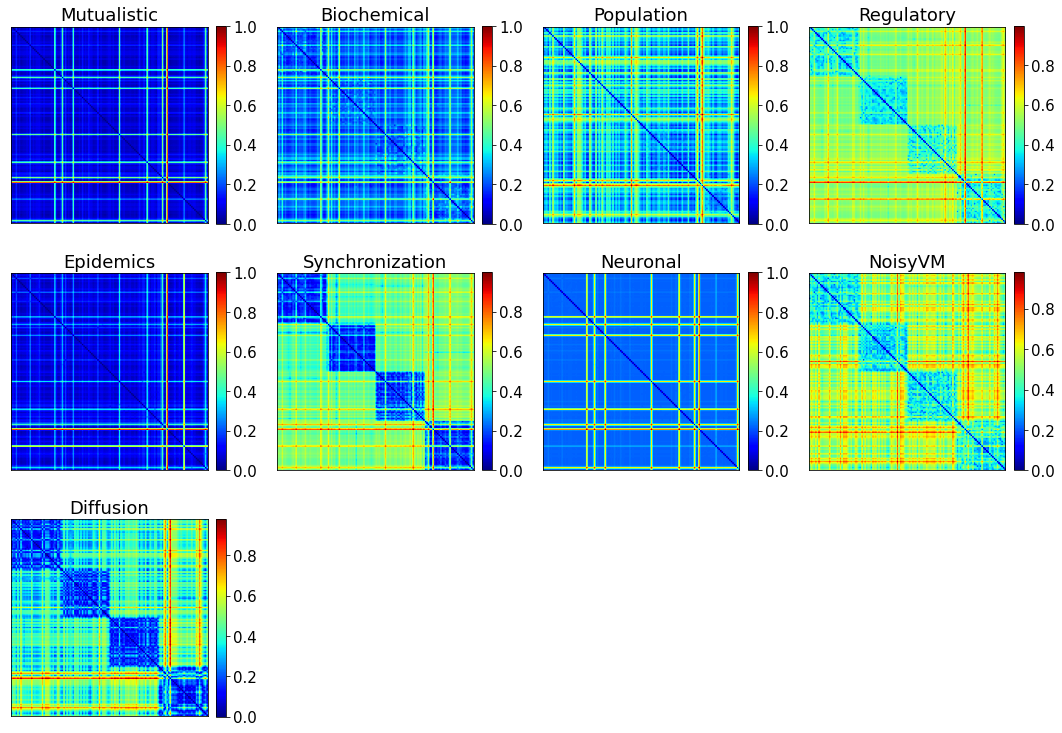

In [165]:
plt.figure(figsize=(15,30))

for i, res in enumerate(results):

    plt.subplot(3,len(results)//2,i+1)
    
    im = plt.imshow(get_average_matrix(res[1]), cmap='jet')
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.xticks([])
    plt.yticks([])
    
    if i==len(dynamics_list):
        plt.title('Diffusion')
    else:
        plt.title(dynamics_list[i])

plt.subplots_adjust(wspace=0, hspace=-1.23)
plt.tight_layout()
plt.show()

# Human connectome

In [4]:
from matplotlib.colors import LogNorm

In [5]:
def remove_digits(string):
    '''
    Remove digits from string
    '''
    return ''.join([i for i in string if not i.isdigit()])

def clean_func_name(string):
    '''
    Clean name of functional networks
    '''
    return string.split('_')[2]

v_remove_digits = np.vectorize(remove_digits)
v_clean_func_name = np.vectorize(clean_func_name)

In [6]:
def eucl_distance_3d(v1, v2):
    '''
    Euclidean distance btw two vectors
    '''
    return np.sqrt( np.sum( (v1-v2)**2 ) )

def find_nearest_single(vect, dataset):
    '''
    Find nearest value in dataset
    '''
    tt = 0
    d_tmp = np.inf
    
    for index, val in enumerate(dataset):
        if eucl_distance_3d(vect, val)<d_tmp:
            d_tmp = eucl_distance_3d(vect, val)
            tt = index
            
    return tt

def find_nearest(dataset1, dataset2):
    '''
    Find nearest value between all elements of two datasets
    '''
    nearest = np.zeros(len(dataset1))
    
    for index, val in enumerate(dataset1):
        nearest[index] = find_nearest_single(val, dataset2)
        
    return nearest.astype(int)

def get_reordered_matrix(mat, order):
    '''
    Get reordered matrix
    '''
    mat_reorder = np.zeros(mat.shape)

    for index, val in enumerate(mat_reorder[order]):
        mat_reorder[index] = mat[order][index][order]
        
    return mat_reorder

def ras_to_mni(vec):
    '''
    From RAS to MNI coordinates
    '''
    t_mat = np.array([[1.0022, 0.0071, -0.0177, 0.0528],
                 [-0.0146, 0.9990, 0.0027, -1.5519],
                 [0.0129, 0.0094, 1.0027, -1.2012]])
    
    vec = np.append(vec, 1.)
        
    return t_mat.dot(vec)

In [7]:
# Load connectivity data
#data_path = '/Users/giacomobarzon/Desktop/jacobian_geometry/data/'
data_path = '/home/barzon/Network_geometry/data/'

connectome = np.loadtxt(data_path+'group_mean_connectivity_matrix_file.txt')
names = np.genfromtxt(data_path+'group_mean_region_names_full_file.txt',dtype='str')
short = np.genfromtxt(data_path+'group_mean_region_names_abbrev_file.txt',dtype='str')
coords = np.loadtxt(data_path+'group_mean_region_xyz_centers_file.txt')

short = v_remove_digits(short) # remove digits from names

# Load functional atlas
# https://github.com/ThomasYeoLab/CBIG/blob/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_900Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv
funct_atlas = np.genfromtxt(data_path+'Schaefer2018_900Parcels_7Networks_order_FSLMNI152_1mm_Centroid_RAS.csv',dtype='str',delimiter=',')
names_func = funct_atlas[1:,1]
coords_func = funct_atlas[1:,2:].astype(float)

names_func = v_clean_func_name(names_func)

rsn = np.unique(names_func)

# Transform RAS to MNI
# * maybe not needed...
coords_func = np.array([ras_to_mni(vec) for vec in coords_func])

In [8]:
# Find RSN to which each structural node belongs to
index_nearest = find_nearest(coords, coords_func)
func_net = names_func[index_nearest]

# Get the reorder for structural nodes
reorder = []

for name in rsn:
    tmp = np.where(func_net == name)[0]
    reorder.append(tmp)
    
reorder = np.concatenate(reorder)

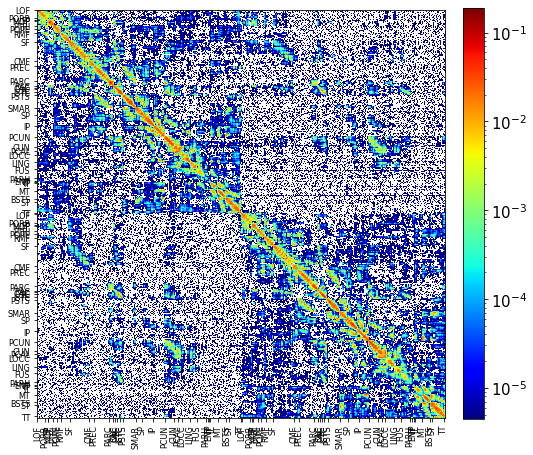

In [9]:
plt.figure(figsize=(8,8))

## Names to print
label_to_print = np.where(short[1:]!=short[:-1])[0] + 1
label_to_print = np.insert(label_to_print, 0, 0)

im = plt.imshow(connectome, cmap='jet', norm=LogNorm())
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.yticks(ticks=label_to_print, labels=short[label_to_print], fontsize=8)
plt.xticks(ticks=label_to_print, labels=short[label_to_print], rotation=90, fontsize=8)

plt.show()

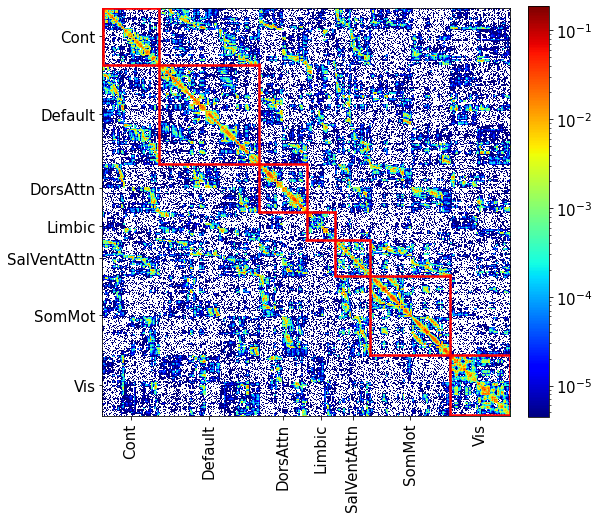

In [105]:
plt.figure(figsize=(8,8))

## Names to print
label_to_print = np.where(short[1:]!=short[:-1])[0] + 1
label_to_print = np.insert(label_to_print, 0, 0)

im = plt.imshow(get_reordered_matrix(connectome, reorder), cmap='jet', norm=LogNorm())
plt.colorbar(im,fraction=0.046, pad=0.04)

net_border = np.where(func_net[reorder][1:] != func_net[reorder][:-1])[0]
net_border = np.append(net_border, len(func_net)-1)

prev = 0
for val in net_border:
    plt.axhline(val, xmin=prev/len(func_net), xmax=val/len(func_net), c='red', lw=lw, zorder=10)
    plt.axvline(val, ymin=1-prev/len(func_net), ymax=1-val/len(func_net), c='red', lw=lw, zorder=10)
    
    plt.axhline(prev, xmin=prev/len(func_net), xmax=val/len(func_net), c='red', lw=lw, zorder=10)
    plt.axvline(prev, ymin=1-prev/len(func_net), ymax=1-val/len(func_net), c='red', lw=lw, zorder=10)
    
    #plt.axhline(val, c='red')
    #plt.axvline(val, c='red')
    prev = val

net_border = np.append(0, net_border)

plt.yticks(ticks=(net_border[1:]+net_border[:-1])/2, labels=rsn)
plt.xticks(ticks=(net_border[1:]+net_border[:-1])/2, labels=rsn, rotation=90)

plt.show()

In [10]:
def Simu(dynamics, G, infoG):
    """
    Inputs: dynamics (any from  dynamics_list = ['Mutualistic', 'Biochemical', 'Population', 'Regulatory',
                                                 'Epidemics','Synchronization', 'Neuronal', 'NoisyVM'])
            Network topology G
            infoG (list): Info about the network. infoG[0] = network_type; infoG[i>0] = parameters
    """
    print('-------- GRAPH DISTANCES --------')
    start_time = time.time()
    
    num_nodes = len(G)
    num_time_points = 200 # small to decrease computational load
    times = np.linspace(0, 400, num = num_time_points) #time to find the steady state    
    #str_tp = "np.logspace(-2, 2., num = num_time_points)" 
    times_perturbation = np.linspace(0, 2000, num = 500)#times at which we look how the perturbation evolves

    if dynamics in ['Mutualistic', 'Population', 'Regulatory','Synchronization', 'Neuronal']:
        perturbation_strength = 0.5
    elif dynamics in ['Biochemical', 'Epidemics', 'NoisyVM']:
        perturbation_strength = 0.05
    else:
        print('Dynamics not valid. Manual Exiting')
        exit()
    
    #if nx.is_connected(G) == 0:
    #    raise ValueError('The network should be in a single component. Exit!')
    
    ### JACOBIAN
    print('[*] JACOBIAN DISTANCE')
    #Integration to get the steady state
    '''
    initial_state = np.random.random(len(G.nodes()))   

    print('Integration up to steady state...')
    SteadyState_ref = cf.Numerical_Integration(G, dynamics, initial_state, times = times, fixed_node = 1e+6, show = 1)
    SteadyState_ref = SteadyState_ref[-1]

    # analytical expression of Jacobian
    print('Evaluating jacobian distance...')
    d_jac = cf.Jacobian(G, dynamics, SteadyState_ref, times_perturbation, return_snapshot=True)
    '''
    ### DIFFUSION
    print('[*] DIFFUSION DISTANCE')
    print('Evaluating diffusion distance...')
    d_diff = cf.Laplacian(G, times_perturbation, norm=True, return_snapshot=True)
    
    return d_diff

In [11]:
res_human = Simu('Synchronization', connectome, [])

-------- GRAPH DISTANCES --------
[*] JACOBIAN DISTANCE
[*] DIFFUSION DISTANCE
Evaluating diffusion distance...


  0%|          | 0/500 [00:00<?, ?it/s]

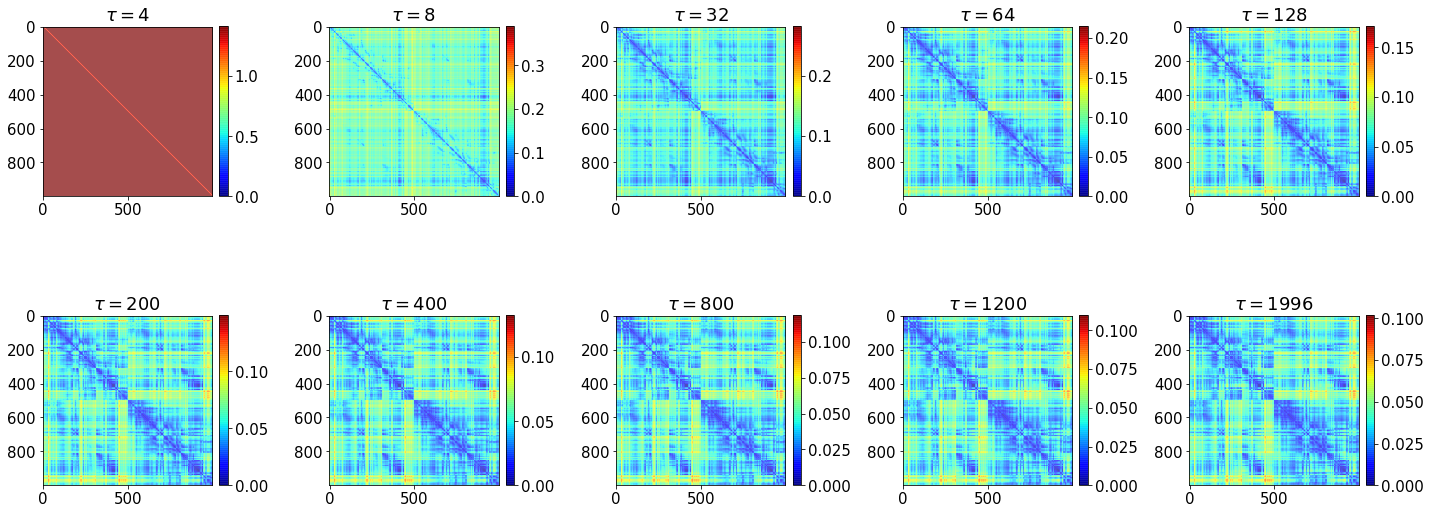

In [18]:
t_print = [1, 2, 8, 16, 32, 50, 100, 200, 300, 499]

plt.figure(figsize=(20,30))

for i, t in enumerate(t_print):
    plt.subplot(2,len(t_print)//2,i+1)
    
    im = plt.imshow(res_human[1][i], cmap='jet', alpha=0.7)
    plt.title(r'$\tau = $'+str(t*4))
    
    plt.colorbar(im, fraction=0.046, pad=0.04)

plt.subplots_adjust(wspace=0, hspace=-1.1)
plt.tight_layout()
plt.show()

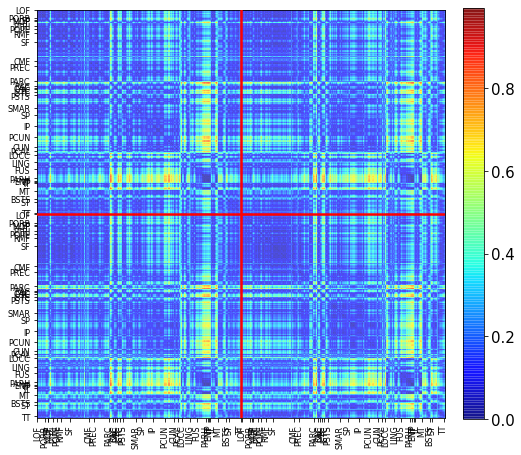

In [20]:
plt.figure(figsize=(8,8))

lw = 2.5

im = plt.imshow(get_average_matrix(res_human[1]), cmap='jet', alpha=0.7)
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.yticks(ticks=label_to_print, labels=short[label_to_print], fontsize=8)
plt.xticks(ticks=label_to_print, labels=short[label_to_print], rotation=90, fontsize=8)

plt.axhline(len(connectome)/2, c='red', lw=lw, zorder=10)
plt.axvline(len(connectome)/2, c='red', lw=lw, zorder=10)

plt.show()

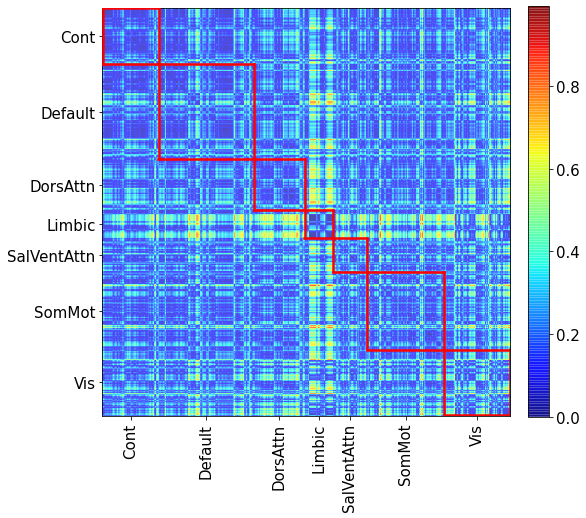

In [21]:
plt.figure(figsize=(8,8))

lw = 2.5

average_dist_mat = get_average_matrix(res_human[1])
im = plt.imshow(get_reordered_matrix(average_dist_mat, reorder), cmap='jet', alpha=0.7)
plt.colorbar(im,fraction=0.046, pad=0.04)

net_border = np.where(func_net[reorder][1:] != func_net[reorder][:-1])[0]
net_border = np.append(net_border, len(func_net)-1)

prev = 0
for val in net_border:
    plt.axhline(val, xmin=prev/len(func_net), xmax=val/len(func_net), c='red', lw=lw, zorder=10)
    plt.axvline(val, ymin=1-prev/len(func_net), ymax=1-val/len(func_net), c='red', lw=lw, zorder=10)
    
    plt.axhline(prev, xmin=prev/len(func_net), xmax=val/len(func_net), c='red', lw=lw, zorder=10)
    plt.axvline(prev, ymin=1-prev/len(func_net), ymax=1-val/len(func_net), c='red', lw=lw, zorder=10)
    
    #plt.axhline(val, c='red')
    #plt.axvline(val, c='red')
    prev = val

net_border = np.append(0, net_border)

plt.yticks(ticks=(net_border[1:]+net_border[:-1])/2, labels=rsn)
plt.xticks(ticks=(net_border[1:]+net_border[:-1])/2, labels=rsn, rotation=90)
    
plt.show()

# Hierarchical clustering

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.spatial.distance as ssd

In [26]:
average_diff = get_average_matrix(res_human[1])

In [65]:
Z = linkage(ssd.squareform(average_diff), optimal_ordering=True, method='average')

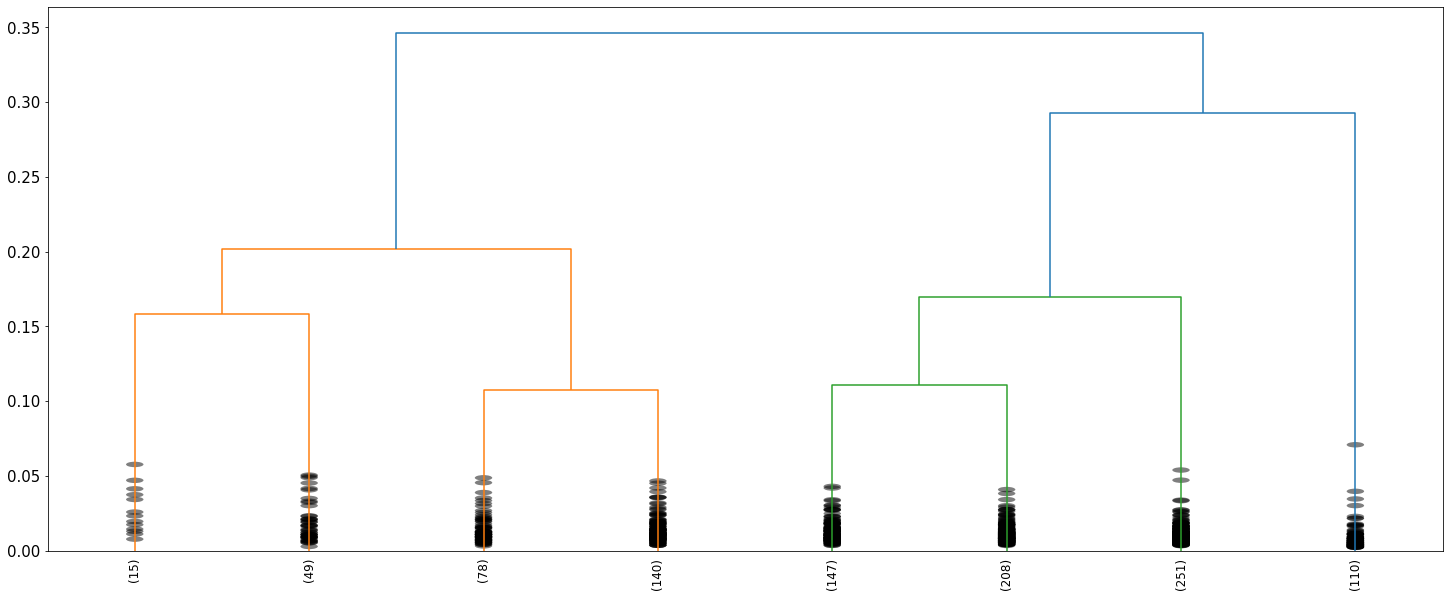

In [69]:
fig = plt.figure(figsize=(25, 10))

dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=8,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)

plt.show()

In [70]:
# plot brain with connectome
# plot resting state networks

# plot connectome nodes with hierarchical clustering

In [72]:
# vedere qual è il numero migliore di cluster

In [99]:
LL = np.eye(len(connectome)) - connectome / np.sum(connectome, axis=0)[:,None]

In [102]:
np.sum(np.abs(LL))

1996.0